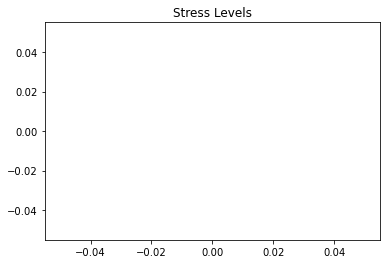

In [2]:
import numpy as np
import dlib
import cv2
from keras.models import load_model
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from scipy.spatial import distance as dist
import imutils
import matplotlib.pyplot as plt
from imutils import face_utils

global points, points_lip, emotion_classifier

def ebdist(leye,reye):
    eyedist = dist.euclidean(leye,reye)
    points.append(int(eyedist))
    return eyedist

def lpdist(l_lower,l_upper):
    lipdist = dist.euclidean(l_lower, l_upper)
    points_lip.append(int(lipdist))
    return lipdist

def emotion_finder(faces,frame):
    EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
    x,y,w,h = face_utils.rect_to_bb(faces)
    frame = frame[y:y+h,x:x+w]
    roi = cv2.resize(frame,(64,64))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi,axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    if label in ['scared','sad','angry']:
        label = 'Stressed'
    else:
        label = 'Not Stressed'
    return label
    
def normalize_values(points,disp,points_lip,dis_lip):
    normalize_value_lip = abs(dis_lip - np.min(points_lip))/abs(np.max(points_lip) - np.min(points_lip))
    normalized_value_eye =abs(disp - np.min(points))/abs(np.max(points) - np.min(points))
    normalized_value =( normalized_value_eye + normalize_value_lip)/2
    stress_value = (np.exp(-(normalized_value)))
    if stress_value>=0.75:
        stress_label="High Stress"
    else:
        stress_label="Low Stress"
    return stress_value,stress_label
    
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
cap = cv2.VideoCapture(0)
points = []
points_lip = []
def get_frame(cap):
    while(True):    
        ret,frame = cap.read()
        frame = cv2.flip(frame,1)
        frame = imutils.resize(frame, width=500,height=500)
        
        (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
        (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
        # lip aka mouth
        (l_lower, l_upper) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
    
    
        #preprocessing the image
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
        detections = detector(gray,0)
        for detection in detections:
            emotion= emotion_finder(detection,gray)
            cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            shape = predictor(frame,detection)
            shape = face_utils.shape_to_np(shape)
               
            leyebrow = shape[lBegin:lEnd]
            reyebrow = shape[rBegin:rEnd]
            openmouth = shape[l_lower:l_upper]
                
            reyebrowhull = cv2.convexHull(reyebrow)
            leyebrowhull = cv2.convexHull(leyebrow)
            openmouthhull = cv2.convexHull(openmouth) # figuring out convex shape when lips opened
    
    #        cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1)
    #        cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)
    #        cv2.drawContours(frame, [openmouthhull], -1, (0, 255, 0), 1)
            
            # Measuring lip aka "open mouth" and eye distance
            lipdist = lpdist(openmouthhull[-1],openmouthhull[0])
            eyedist = ebdist(leyebrow[-1],reyebrow[0])
    
            stress_value,stress_label = normalize_values(points,eyedist, points_lip, lipdist)
                
            cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame,"stress value:{}".format(str(int(stress_value*100))),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame,"Stress level:{}".format((stress_label)),(10,60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.imshow("Frame", frame)
    
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
    cv2.destroyAllWindows()
    cap.release()
plt.plot(range(len(points)),points,'ro')
plt.title("Stress Levels")
plt.show()